###Install dependencies

In [1]:
pip install openai spacy pytextrank

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.0/77.0 kB 2.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
llmx 0.0.15a0 requires cohere, which is not installed.
llmx 0.0.15a0 requires tiktoken, which is not installed.


###Set up OpenAI Api Key

In [2]:
#get OPENAI API key
from google.colab import userdata
api_key = userdata.get('openai')

###import dependencies

In [3]:
#import dependencies
import os
import openai
import pandas as pd
import spacy
import pytextrank
import re
import numpy as np
import json
import networkx as nx
import matplotlib.pyplot as plt

pd.set_option('display.max_colwidth', 200)
%matplotlib inline

###Load input data along with english vocabulary

In [4]:
#Load in data
docs = pd.read_csv('usnewspaper_tech.csv', header=None, sep=',')

#install english vocabulary
#spacy.cli.download("en_core_web_sm")
nlp = spacy.load('en_core_web_sm')

#add in textrank to pipeline
nlp.add_pipe("textrank")

###Preprocess text

In [5]:
#remove special characters from passages
def clean_text(text):
    return re.sub(r'[^\x00-\x7F]+','',text)

#Add in raw and cleaned text data to a new dataframe
new_docs = pd.DataFrame()
new_docs['RAW_TEXT'] = docs.iloc[:,0]

#remove NaNs and Nulls if any
new_docs.dropna(inplace=True)

#vectorize function
v = np.vectorize(clean_text)

#map to new column
new_docs['CLEAN_TEXT'] = v(new_docs['RAW_TEXT'])

#remove duplicates from text
new_docs = new_docs.drop_duplicates(subset=['CLEAN_TEXT'], keep='first')

len(new_docs)

6564

In [6]:
new_docs.head()

,RAW_TEXT,CLEAN_TEXT
0,"First Horizon Advisors Inc. trimmed its holdings in iShares Biotechnology ETF (NASDAQ:IBB – Get Rating) by 6.1% in the third quarter, according to the company in its most recent filing with the SE...","First Horizon Advisors Inc. trimmed its holdings in iShares Biotechnology ETF (NASDAQ:IBB Get Rating) by 6.1% in the third quarter, according to the company in its most recent filing with the SEC..."
1,Register for more free articles. Sign up for our newsletter to keep reading.\n\nBe the first to know Get local news delivered to your inbox! Sign up! Already a Subscriber? Already a Subscriber? Si...,Register for more free articles. Sign up for our newsletter to keep reading.\n\nBe the first to know Get local news delivered to your inbox! Sign up! Already a Subscriber? Already a Subscriber? Si...
2,"Business Today: the best news, analysis and comment from The Irish Times business desk","Business Today: the best news, analysis and comment from The Irish Times business desk"
3,Cookie Preferences Cookie List\n\nCookie List\n\nA cookie is a small piece of data (text file) that a website – when visited by a user – asks your browser to store on your device in order to remem...,Cookie Preferences Cookie List\n\nCookie List\n\nA cookie is a small piece of data (text file) that a website when visited by a user asks your browser to store on your device in order to remembe...
4,"Fintech StellarFi, which helps people improve their credit score, just raised $15 million.\n\nThe startup pools customer debts, repays them on time, and reports them to credit bureaus.\n\nCheck ou...","Fintech StellarFi, which helps people improve their credit score, just raised $15 million.\n\nThe startup pools customer debts, repays them on time, and reports them to credit bureaus.\n\nCheck ou..."


###Extract keywords with rank more than 0.12 from all passages
rank threshold is set to 0.12 to limit the no. of keywords generated per passage for a concise and accurate KG.

In [7]:
def extract_keywords(passage):
    keywords = []
    doc = nlp(passage)
    keywords = [k.text for k in doc._.phrases if k.rank > 0.12]
    return keywords


In [8]:
new_docs['Keywords'] = new_docs['CLEAN_TEXT'].apply(extract_keywords)
new_docs.head(10)

,RAW_TEXT,CLEAN_TEXT,Keywords
0,"First Horizon Advisors Inc. trimmed its holdings in iShares Biotechnology ETF (NASDAQ:IBB – Get Rating) by 6.1% in the third quarter, according to the company in its most recent filing with the SE...","First Horizon Advisors Inc. trimmed its holdings in iShares Biotechnology ETF (NASDAQ:IBB Get Rating) by 6.1% in the third quarter, according to the company in its most recent filing with the SEC...","[iShares Biotechnology ETF, iShares Biotechnology ETF alerts, iShares Biotechnology, iShares Biotechnology ETFs, Get iShares Biotechnology]"
1,Register for more free articles. Sign up for our newsletter to keep reading.\n\nBe the first to know Get local news delivered to your inbox! Sign up! Already a Subscriber? Already a Subscriber? Si...,Register for more free articles. Sign up for our newsletter to keep reading.\n\nBe the first to know Get local news delivered to your inbox! Sign up! Already a Subscriber? Already a Subscriber? Si...,"[Service Privacy Policy, local news]"
2,"Business Today: the best news, analysis and comment from The Irish Times business desk","Business Today: the best news, analysis and comment from The Irish Times business desk","[The Irish Times business desk, comment, analysis, The Irish Times, Business Today: the best news]"
3,Cookie Preferences Cookie List\n\nCookie List\n\nA cookie is a small piece of data (text file) that a website – when visited by a user – asks your browser to store on your device in order to remem...,Cookie Preferences Cookie List\n\nCookie List\n\nA cookie is a small piece of data (text file) that a website when visited by a user asks your browser to store on your device in order to remembe...,[such cookies]
4,"Fintech StellarFi, which helps people improve their credit score, just raised $15 million.\n\nThe startup pools customer debts, repays them on time, and reports them to credit bureaus.\n\nCheck ou...","Fintech StellarFi, which helps people improve their credit score, just raised $15 million.\n\nThe startup pools customer debts, repays them on time, and reports them to credit bureaus.\n\nCheck ou...",[]
5,"There are several different fast-growing industries that investors can put their money behind. Streaming entertainment, artificial intelligence (AI), and e-commerce are some popular ones. A long e...","There are several different fast-growing industries that investors can put their money behind. Streaming entertainment, artificial intelligence (AI), and e-commerce are some popular ones. A long e...",[]
7,"Copyright 2023 The Associated Press. All rights reserved. This material may not be published, broadcast, rewritten or redistributed without permission.","Copyright 2023 The Associated Press. All rights reserved. This material may not be published, broadcast, rewritten or redistributed without permission.",[permission]
8,— Recommendations are independently chosen by Reviewed’s editors. Purchases you make through our links may earn us and our publishing partners a commission.\n\nBest Buy is turning up the heat with...,Recommendations are independently chosen by Revieweds editors. Purchases you make through our links may earn us and our publishing partners a commission.\n\nBest Buy is turning up the heat with e...,"[Best Buy sales, Best Buy tech deals, Best Buy laptop deals, Best Buy TV deals, Best Buy, Best Buy tablet, Featured Best Buy, Best Buy`s daily deals]"
9,"Listen 8 min Comment on this story Comment Gift Article Share\n\nRIGA, Latvia — The bank worker logs into work each day around noon — 8 a.m. in Moscow — from his rental in Southeast Asia, where he...","Listen 8 min Comment on this story Comment Gift Article Share\n\nRIGA, Latvia The bank worker logs into work each day around noon 8 a.m. in Moscow from his rental in Southeast Asia, where he en...",[]
10,"Welcome to the first of a special spin-off series of The Fintech Show: “How to Build a Bank”, sponsored by our friends over at Mambu. In this 3-part series, we speak to various diffe

###remove rows with a single or zero keyword

In [9]:
index_to_drop = []
for idx,keyword in enumerate(new_docs['Keywords']):
    if len(keyword)<=1:
        index_to_drop.append(idx)
docs = new_docs.drop(index=new_docs.index[index_to_drop],axis=0)

print(f'No.of rows dropped due to insufficient #keywords={len(index_to_drop)}')
print(f'No.of rows to process={len(docs)}')

No.of rows dropped due to insufficient #keywords=4830
No.of rows to process=1734


In [10]:
docs.head()

,RAW_TEXT,CLEAN_TEXT,Keywords
0,"First Horizon Advisors Inc. trimmed its holdings in iShares Biotechnology ETF (NASDAQ:IBB – Get Rating) by 6.1% in the third quarter, according to the company in its most recent filing with the SE...","First Horizon Advisors Inc. trimmed its holdings in iShares Biotechnology ETF (NASDAQ:IBB Get Rating) by 6.1% in the third quarter, according to the company in its most recent filing with the SEC...","[iShares Biotechnology ETF, iShares Biotechnology ETF alerts, iShares Biotechnology, iShares Biotechnology ETFs, Get iShares Biotechnology]"
1,Register for more free articles. Sign up for our newsletter to keep reading.\n\nBe the first to know Get local news delivered to your inbox! Sign up! Already a Subscriber? Already a Subscriber? Si...,Register for more free articles. Sign up for our newsletter to keep reading.\n\nBe the first to know Get local news delivered to your inbox! Sign up! Already a Subscriber? Already a Subscriber? Si...,"[Service Privacy Policy, local news]"
2,"Business Today: the best news, analysis and comment from The Irish Times business desk","Business Today: the best news, analysis and comment from The Irish Times business desk","[The Irish Times business desk, comment, analysis, The Irish Times, Business Today: the best news]"
8,— Recommendations are independently chosen by Reviewed’s editors. Purchases you make through our links may earn us and our publishing partners a commission.\n\nBest Buy is turning up the heat with...,Recommendations are independently chosen by Revieweds editors. Purchases you make through our links may earn us and our publishing partners a commission.\n\nBest Buy is turning up the heat with e...,"[Best Buy sales, Best Buy tech deals, Best Buy laptop deals, Best Buy TV deals, Best Buy, Best Buy tablet, Featured Best Buy, Best Buy`s daily deals]"
13,"Kamal Kapadia`s tech startup had all of its money in Silicon Valley Bank. They`re still trying to access their funds, days after it collapsed.","Kamal Kapadia`s tech startup had all of its money in Silicon Valley Bank. They`re still trying to access their funds, days after it collapsed.","[Silicon Valley Bank, Kamal Kapadia`s tech startup, days]"


###Invoke openai's gpt3.5-turbo api to extract relations among multiple entities

In [20]:
openai.api_key = api_key

prompt = """ Given the following passage and phrases, extract the relationships as verbs and prepositions between the phrases
while STRICTLY following these rules
1. relation must be accurate and must NOT be more than 50 characters. If you cannot find any information on the entities and
relationships above, it is okay to return empty value.
2. Do NOT create fictious data.
3. Never impute missing values
4. The output content should be in json format
5. If you will be unable to fit a full relationship pairing from one entity to another entity within the token limit,
please DO NOT include that entry in the response """



def extract_relations(passage:str,entity_list:list):
    response = openai.ChatCompletion.create(
                model="gpt-3.5-turbo",
                messages=[
                {"role": "system", "content": "You are a helpful assistant that extracts relationships that connects multiple entities."},
                {"role": "user", "content": f"{prompt}, passage:{passage}, phrases: {entity_list}"}
                 ],
                temperature=0,
                max_tokens=1024 )

    return response.choices[0]["message"]["content"]

###Select sample of passages to run inference on and proceed with Knowledge Graph

In [23]:
relations = []
for n,text in enumerate(docs['CLEAN_TEXT'][:4]):
    res = extract_relations(text,docs['Keywords'].iloc[n])
    result = json.loads(res)
    relations.append(result['relationships'])


###Create DataFrame with entities and relations

In [24]:
df = pd.DataFrame(columns=['entity1','entity2','relationship','index'])
df1 = pd.DataFrame()
df_merged = pd.DataFrame()

for id,rel in enumerate(relations):
    df1 = pd.DataFrame(rel)
    df1['index'] = id
    df_merged = pd.concat([df,df1], ignore_index=True, sort=False)
    df = df1
df_merged.head()


,entity1,relation,entity2,index,relationship
0,The Irish Times business desk,from,Business Today: the best news,2,NaN
1,The Irish Times business desk,comment,comment,2,NaN
2,The Irish Times business desk,analysis,analysis,2,NaN
3,The Irish Times business desk,from,The Irish Times,2,NaN
4,Best Buy sales,NaN,major discounts,3,offer


In [25]:
df_merged

,entity1,relation,entity2,index,relationship
0,The Irish Times business desk,from,Business Today: the best news,2,NaN
1,The Irish Times business desk,comment,comment,2,NaN
2,The Irish Times business desk,analysis,analysis,2,NaN
3,The Irish Times business desk,from,The Irish Times,2,NaN
4,Best Buy sales,NaN,major discounts,3,offer
5,Best Buy tech deals,NaN,awesome deals,3,provide
6,Best Buy laptop deals,NaN,discounts,3,offer
7,Best Buy TV deals,NaN,discounts,3,provide
8,Best Buy,NaN,My Best Buy membership program,3,launch
9,Best Buy,NaN,daily deals,3,have


##Generate KG using networkx

###KG for first passage

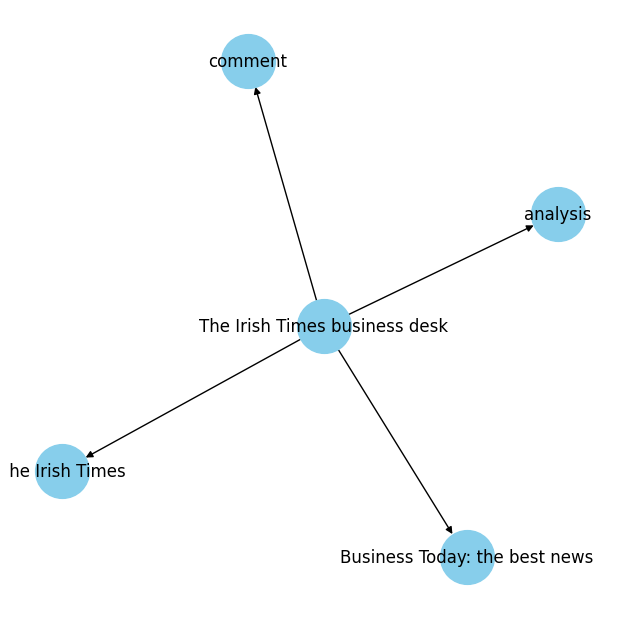

In [29]:
import networkx as nx
import matplotlib.pyplot as plt


pd.set_option('display.max_colwidth', 200)
%matplotlib inline

G=nx.from_pandas_edgelist(df_merged[df_merged['index']==2], "entity1", "entity2",
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(6,6))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

###KG for passage 3

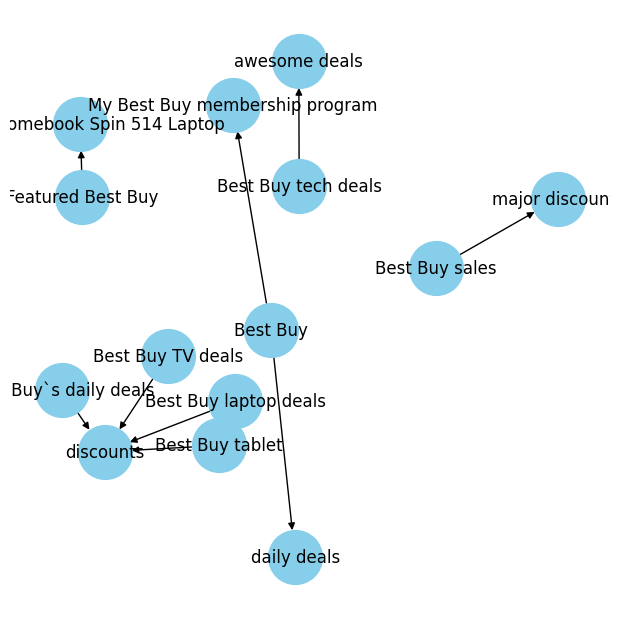

In [27]:
G=nx.from_pandas_edgelist(df_merged[df_merged['index']==3], "entity1", "entity2",
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(6,6))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()